# MLE Estimation Code
The code below is used to calculate our maximum likelihood estimates and all robustness checks aside from the GMM estimation. For it to work properly the cit_external_comn_share.csv dataset must be stored in the same file.

This first cell imports the necessary packages.

In [1]:
# Import packages
import pandas as pd
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#Setting plot colors
cmap1 = matplotlib.cm.get_cmap('summer')
%matplotlib notebook

The cell below loads the data as a pandas dataset. We use the pandas package because we find that it makes data-manipulation easier compared with numpy arrays. The last line in the cell removes patent observations before 1975.

In [2]:
#Loading data as a pandas dataset
data2 = pd.read_csv('cit_external_comn_share.csv', sep = ',', header = 0, index_col = 0)
#Deleting patents before 1976
data2 = data2[data2.appyear > 1975]

C:\Users\Scott\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In this cell we set the percentile cutoff that defines abrupt patents. The default is .1, which means that patents in the upper ten percent of the citation distribution are classified as abrupt. The code translates this percentile into a cutoff in terms of the number of citations. The variable abr_cutoff can be changed as a robustness check. 

In [3]:
#Setting the percentile cutoff that defines abrupt patents
abr_cut = 0.1
#For patents with zero citations, their share of citations from external sources is NAN. Here we replace NANs with -1.
data2['external_share'] = data2.external_share.replace(np.nan, -1)
#This gives the ranking of the patent with the lowest number of citations to be classified as abrupt, given our cutoff
level = np.rint(np.size(data2['tot_cit_correct'].dropna())
                                                   - abr_cut * np.size(data2['tot_cit_correct'].
                                                                   dropna()))
#This gives the number of citations above which a patent is abrupt.
cutoff = np.sort(data2['tot_cit_correct'].dropna())[int(level)]
cutoff

10.6616

The code below creates indicator variables for whether a patent is abrupt and for whether it is external. It also creates a variable for the number of same-class citations received by abrupt patents (called tot_external_class_correct). This is the main empirical variable that we will use in the estimations.

In [5]:
#This function will be used to determine whether a patent is abrupt or incremental.
#A patent at the top 10% of expected citations is set to be aprupt

def abrupt(cites, cutoff):
    if cites >= cutoff:
        return 0
    else:
        return 1
    
#Creating a new column for the indicator variable 'incremental'
data2['Increment'] = data2['tot_cit_correct'].apply(abrupt, cutoff = cutoff)
#Creating a new column internal citations to abrupt patents
data2['tot_abr_inc_cit_correct'] = data2['tot_cit_correct'] - data2['tot_external_correct']
#Creating a new column for same-class citations to abrupt patents
data2['tot_abr_class_cit_correct'] = data2['tot_cit_correct'] - data2['tot_external_class_correct']

#Defining External Patents
#The definition will depend on the share of citations that are external.
#That variable has many missing values for patents with no citations. This line replaces
#those missing values with -1. 
data2['external_share'] = data2.external_share.replace(np.nan, -1)
#Now I define a function to determine whether a patent is external
def external(cites):
    cutoff = 0.5
    if cites >= cutoff:
        return 1
    else:
        return 0
#Creating indicator variable for external patents
data2['External'] = data2['external_share'].apply(external)

### Generating graphs of Theoretical Distributions
The following two cells are used to get a picture of how each parameter impacts the theoretical distribution. The first cell defines functions to calculate the theoretical distributions. The next cell graphs the distribution for different parameter values.

Three functions are defined in the cell below:
1. pdf_eta2 takes in parameter values and ndim, which is a variable determining how many terms to include in our infinite sequence approximation. The function outputs a vector containing the theoretical pmf values for integers one through ndim - 1.

2. pdf_eta_norm is called by the following function pdf_citations2. It takes in lambda_inc_k (which is a sequence of endogenous variables calculated by the parameters) and other parameter values. It outputs the theoretical pmf when the probability is equal to one.

3. The function pdf_citations2 is the analog of pdf_eta2 when the probability of citing is equal to 0.75. It takes in parameter values and outputs theoretical pmf values.

In [6]:
def pdf_eta2(lambda_inc_0, alpha, tau_lambda_int_abr, ndim):
    seq = np.arange(ndim)
    lambda_inc_k = np.array(lambda_inc_0 * alpha**seq)
    eta_0 = (tau_lambda_int_abr)/(lambda_inc_k[0] + tau_lambda_int_abr)
    #eta_0 = (tau_lambda_int_abr)/(lambda_inc_k[0])
    eta_k_mod = [None] * ndim
    eta_k_mod[0] = eta_0
    for i in range(1, np.size(lambda_inc_k)):
        eta_k_mod[i] = eta_k_mod[i-1] * ((lambda_inc_k[i-1])/(lambda_inc_k[i] + tau_lambda_int_abr))
        
    return eta_k_mod

def pdf_eta_norm(lambda_inc_k, tau_lambda_int_abr):
    
    eta_0 = (tau_lambda_int_abr)/(lambda_inc_k[0] + tau_lambda_int_abr)
    eta_k_mod = [None] * len(lambda_inc_k)
    eta_k_mod[0] = eta_0
    for i in range(1, np.size(lambda_inc_k)):
        eta_k_mod[i] = eta_k_mod[i-1] * ((lambda_inc_k[i-1])/(lambda_inc_k[i] + tau_lambda_int_abr))
    
    return eta_k_mod

def pdf_citations2(lambda_inc_0, tau_lambda_int_abr, alpha, ndim):
    probability = 0.75
    seq = np.arange(ndim)
    lambda_inc_k = np.array(lambda_inc_0 * alpha**seq)
    etas = pdf_eta_norm(lambda_inc_k, tau_lambda_int_abr)
    pmf = np.zeros(len(etas))
    M = np.zeros((len(etas), len(etas)))
    for i in range(0, len(etas)):
        for j in range(0, len(etas)):
            M[i][j] = sts.binom.pmf(i, j, probability)
    pmf = np.dot(M, etas)
    
    return pmf

This cell caclulates and plots the theoretical distribution for various parameter values. It is currently set to plot three distributions when probability of citing is equal to one and the main two parameters are variable (this is the setup for our baseline estimation). The plot commands can be changed to show the distribution with probability of citing equal to 0.75.

<IPython.core.display.Javascript object>


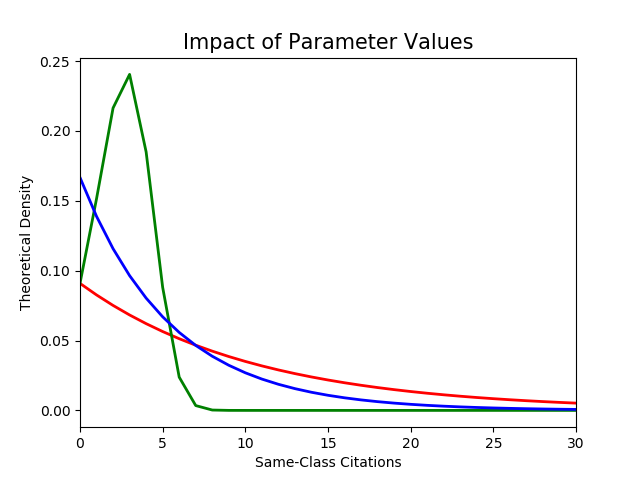

In [7]:
#The length of our pmf vector will be 100 (increasing this does not change the results significantly)
ndim = 100
#Defining parameter values
lambda_inc_0_test, alpha_test, tau_lambda_int_abr_test = 1.0, 1.0 , .1
#Calculating pmf when probability of citing is equal to .75
pmf = pdf_citations2(lambda_inc_0_test, tau_lambda_int_abr_test, alpha_test, ndim)
#Calculating pmf when probability of citing is equal to one
pmf2 = pdf_eta2(lambda_inc_0_test, alpha_test, tau_lambda_int_abr_test, ndim)
#Calculating pmf for low alpha
pmf3 = pdf_eta2(lambda_inc_0_test, alpha_test*.5, tau_lambda_int_abr_test, ndim)
#Calculating pmf for large abrupt arrival rate
pmf4 = pdf_eta2(lambda_inc_0_test, alpha_test, tau_lambda_int_abr_test*2, ndim)

#Plotting theoretical distributions
dist_pts = np.arange(ndim)
plt.figure(7)
plt.plot(dist_pts, pmf2,
         linewidth=2, color='r', label = '1: $\alpha$')
plt.plot(dist_pts, pmf3,
         linewidth=2, color='g', label = '2: $\alpha$')
plt.plot(dist_pts, pmf4,
         linewidth=2, color='b', label = '3: $\alpha$')
plt.xlim([0, 30])
plt.title('Impact of Parameter Values', fontsize=15)
plt.xlabel('Same-Class Citations')
plt.ylabel('Theoretical Density')
plt.legend(loc='upper left')

### Basline Maximum Likelihood Estimation

The following two cells calculate the maximum likelihood estimates for our baseline estimation (with two parameters: $\alpha$ and $\frac{\tau + \lambda_{abr, int}}{\lambda_{inc, 0}}$).

The cell directly below defines three functions:
1. pdf_eta_norm calculates the theoretical distribution. It is called by the log_likelihood function.
2. log_lik calculates the log-likelihood of the data given a set of parameters.
3. crit is the criterion function to be minimized. It returns the negative log-likelihood for a given set of parameters.

In [9]:
def pdf_eta_norm(lambda_inc_k, tau_lambda_int_abr):
    
    eta_0 = (tau_lambda_int_abr)/(lambda_inc_k[0] + tau_lambda_int_abr)
    eta_k_mod = [None] * len(lambda_inc_k)
    eta_k_mod[0] = eta_0
    for i in range(1, np.size(lambda_inc_k)):
        eta_k_mod[i] = eta_k_mod[i-1] * ((lambda_inc_k[i-1])/(lambda_inc_k[i] + tau_lambda_int_abr))
    
    return eta_k_mod

def log_lik(xvals, lambda_inc_k, alpha, tau_lambda_int_abr):
    lik_array = np.zeros(len(xvals))
    pmf = pdf_eta_norm(lambda_inc_k, tau_lambda_int_abr)
    rounded = np.round(xvals)
    for n in range(0, len(xvals)):
        lik_array[n] = pmf[np.int(rounded[n])]
    
    lik_array[lik_array < 1e-20] = 1e-20
    loglik_array = np.log(lik_array)
    
    return np.sum(loglik_array)

def crit(params, *args):
    tau_lambda_int_abr, alpha = params
    xvals, W, ndim = args
    lambda_inc_0 = 1.0
    seq = np.arange(ndim)
    lambda_inc_k = np.array(lambda_inc_0 * alpha**seq)
    loglik = log_lik(xvals, lambda_inc_k, alpha, tau_lambda_int_abr)
    crit_val = -loglik
    #print(params, crit_val)
    
    return crit_val

This cell runs the baseline estimation. Initial values can be adjusted to test the robustness of the estimates.

In [10]:
#MLE with all data and probability fixed at one.
#Creating a vector containing the empirical distribution
cit_abr = data2[(data2.Increment == 0)]
MLE_data = np.array(cit_abr.tot_abr_class_cit_correct.dropna())
#Setting initial parameter values
tau_lambda_int_abr_init = .09
lambda_inc_0_init = 0.5
alpha_init = 0.95
params_init = np.array([tau_lambda_int_abr_init, alpha_init])
#Setting parameter bounds
bnds = ((1e-5, None),(1e-5, 1-1e-5))
#Setting the number of dimensions to be 750
ndim = 750
M = np.zeros((ndim, ndim))
#Observations larger than the maximum citations ndim-1 are rounded down (with ndim>741, this has no effect)
for i in range(0, len(MLE_data)):
    if MLE_data[i] > ndim -1:
        MLE_data[i] = ndim-1
#Setting MLE arguments
gmm_args = (MLE_data, M, ndim)

#Running the estimation and printing results
results_MLE = opt.minimize(crit, params_init, args=(gmm_args),
                                 method='L-BFGS-B', bounds = bnds)

tau_lambda_int_abr_old, alpha_old = results_MLE.x
print('ratio_MLE=', tau_lambda_int_abr_old,
      'alpha_MLE=', alpha_old)
print('-log likelihood =', results_MLE.fun)

tau_lambda_int_abr_MLE= 0.0994645686415 alpha_MLE= 0.99999
-log likelihood = 634983.15129


Plotting the theoretical distribution against the empirical data:

<IPython.core.display.Javascript object>


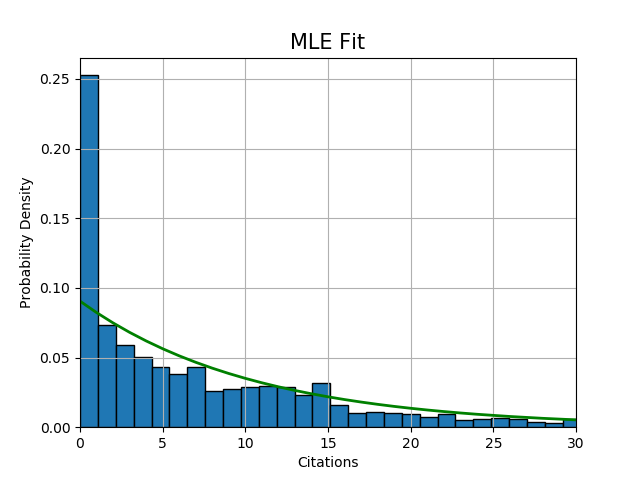

In [17]:
# Plot the histogram of the data
#Total same class citations to abrupt patents
data3 = data2[(data2.Increment == 0)]
data3.hist(column = 'tot_abr_class_cit_correct', normed=True, bins = 400, edgecolor = 'black')
plt.title('MLE Fit', fontsize=15)
plt.xlabel('Citations')
plt.ylabel('Probability Density')
plt.xlim([0, 30])
dist_pts = np.arange(ndim)
plt.plot(dist_pts, pdf_eta2(1.0, alpha_old, tau_lambda_int_abr_old, ndim),
         linewidth=2, color='g')
plt.legend(loc='upper right')

This cell runs the same estimation where observations in the upper tail are eliminated. We see that alpha is still equal to one while the relative amount of abrupt patents is larger.

In [18]:
#This runs the optimization with p=1 when the upper tail of the distribution is eliminated
cit_abr = data2[(data2.Increment == 0)]
cit_abr = cit_abr[cit_abr.tot_abr_class_cit_correct < 50]

tau_lambda_int_abr_init = .09
lambda_inc_0_init = 0.5
alpha_init = 0.95
params_init = np.array([tau_lambda_int_abr_init, alpha_init])
bnds = ((1e-5, None),(1e-5, 1-1e-5))
ndim = 750
M = np.zeros((ndim, ndim))
MLE_data = np.array(cit_abr.tot_abr_class_cit_correct.dropna())
for i in range(0, len(MLE_data)):
    if MLE_data[i] > ndim -1:
        MLE_data[i] = ndim-1
gmm_args = (MLE_data, M, ndim)

results_MLE = opt.minimize(crit, params_init, args=(gmm_args),
                                 method='L-BFGS-B', bounds = bnds)

tau_lambda_int_abr_MLE, alpha_MLE = results_MLE.x
print('tau_lambda_int_abr_MLE=', tau_lambda_int_abr_MLE,
      'alpha_MLE=', alpha_MLE)
print('-log likelihood =', results_MLE.fun)

tau_lambda_int_abr_MLE= 0.127039761201 alpha_MLE= 0.99999
-log likelihood = 575622.14203


Plotting the fit of the model when the upper tail is eliminated compared with the baseline:

<IPython.core.display.Javascript object>


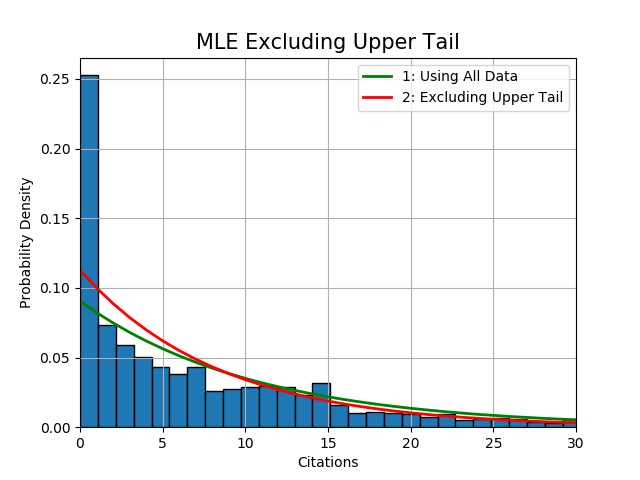

In [19]:
# Plot the histogram of the data
#Total same class citations to abrupt patents
data3 = data2[(data2.Increment == 0)]
data3.hist(column = 'tot_abr_class_cit_correct', normed=True, bins = 400, edgecolor = 'black')
plt.title('MLE Excluding Upper Tail', fontsize=15)
plt.xlabel('Citations')
plt.ylabel('Probability Density')
plt.xlim([0, 30])
dist_pts = np.arange(ndim)
plt.plot(dist_pts, pdf_eta2(1.0, alpha_old, tau_lambda_int_abr_old, ndim),
         linewidth=2, color='g', label='1: Using All Data')
plt.plot(dist_pts, pdf_eta2(1.0, alpha_MLE, tau_lambda_int_abr_MLE, ndim),
         linewidth=2, color='r', label = '2: Excluding Upper Tail')
plt.legend(loc='upper right')

Now we calculate the actual values of parameters $\lambda_{inc, 0}$ and $\tau + \lambda_{abr, int}$ for our baseline estimation. For a given value of the ratio between these parameters, there exists a unique solution where the model's R&D intensity is equal to the actual R&D intensity value from compustat. The function crit_solve (defined below) solves for these values.

This cell also calculates an untargeted moment: R&D share. The match between the model moment and the data moment is printed out. We see that our baseline MLE estimate does a good job of matching this moment.

In [16]:
#This function will be minimized to find the proper lambda_inc_0.
def crit_solve(params, *args):
    lambda_inc_0 = params
    ratio, alpha, ndim = args
    tau_lambda_int_abr = ratio*lambda_inc_0
    seq = np.arange(ndim)
    lambda_inc_k = np.array(lambda_inc_0 * alpha**seq)
    sum_eta = np.sum(pdf_eta_norm(lambda_inc_k, tau_lambda_int_abr))
    temp = np.reshape(pdf_eta_norm(lambda_inc_k, tau_lambda_int_abr), (750, ))
    lambda_inc = np.dot(temp, lambda_inc_k)
    share_inc_mod3 = lambda_inc / (lambda_inc + tau_lambda_int_abr)
    RD_intens_mod3 = 0.106 * 0.346 * (1 / (share_inc_mod3)) * np.dot(temp,
                                             np.multiply(lambda_inc_k, lambda_inc_k)
                                            ) / 0.075547
    RD_intens_data = 0.06797109
    error = RD_intens_mod3 - RD_intens_data
    return error*error


ndim = 750
args = tau_lambda_int_abr_old, alpha_old, ndim
params_init = .5
bnds = ((1e-10, None), )
results = opt.minimize(crit_solve, params_init, args=args,
                                 method='L-BFGS-B', bounds = bnds)
lambda_0 = results.x
print('Actual lambda_inc_0_MLE:',lambda_0,'tau_lambda_abr_MLE', lambda_0*tau_lambda_int_abr_old)

#other moments
seq = np.arange(ndim)
lambda_inc_k_MLE = np.array(1.0 * alpha_old**seq)
sum_eta = np.sum(pdf_eta_norm(lambda_inc_k_MLE, tau_lambda_int_abr_old))
lambda_inc_MLE = np.dot(pdf_eta_norm(lambda_inc_k_MLE, tau_lambda_int_abr_old), lambda_inc_k_MLE)
#share of incremental patents
cit_inc = data2[(data2.Increment == 1)]
share_inc_data = np.size(np.array(cit_inc.patent)) / (np.size(np.array(cit_inc.patent)) +
                                     np.size(np.array(cit_abr.patent)))
share_inc_mod3 = 1.0 / (1.0 + tau_lambda_int_abr_old)
print('data share:', share_inc_data, 'MLE share:', share_inc_mod3)

Actual lambda_inc_0_MLE: [ 0.35690161] tau_lambda_abr_MLE [ 0.03549906]
data share: 0.9023567649610403 MLE share: 0.909533629843


The following cell repeats the baseline estimation when alpha is fixed at one. We see that the results are similar, which gives us confidence that we have found a global minimum in the criterion function.

In [23]:
def crit_log_lik_noalpha(params, *args):
    tau_lambda_int_abr = params
    lambda_inc_0 = 1.0
    xvals, W, ndim, alpha = args
    seq = np.arange(ndim)
    lambda_inc_k = np.array(lambda_inc_0 * alpha**seq)
    loglik = log_lik(xvals, lambda_inc_k, alpha, tau_lambda_int_abr)
    crit_val = -loglik
    #print(params, crit_val)
    
    return crit_val

tau_lambda_int_abr_init = .05
params_init = np.array([tau_lambda_int_abr_init])
bnds = ((1e-5, None), )
ndim = 750
alpha_MLE2 = 1.0
W = np.eye(3)
cit_abr = data2[(data2.Increment == 0)]
MLE_data = np.array(cit_abr.tot_abr_class_cit_correct.dropna())
gmm_args = (MLE_data, W, ndim, alpha_MLE2)


results_MLE = opt.minimize(crit_log_lik_noalpha, params_init, args=(gmm_args),
                                 method='L-BFGS-B', bounds = bnds)

tau_lambda_int_abr_MLE2 = results_MLE.x
lambda_inc_0_MLE = 1.0
print('tau_lambda_int_abr_MLE=', tau_lambda_int_abr_MLE2,
      'alpha_MLE=', alpha_MLE2)
print('-log likelihood =', results_MLE.fun)

tau_lambda_int_abr_MLE= [ 0.09948487] alpha_MLE= 1.0
-log likelihood = 634963.558359


The next two cells relax the assumption that the probability of citing is equal to one. We see that the results are similar.

The first cell defines the required functions:
1. pdf_citations calculates the theoretical distribution. It is called by the log-likelihood function. Information about the probability of citing is stored in the input matrix M.
2. log_lik2 calculates the log-likelihood function.
3. crit3 is the criterion function to be minimized.

In [24]:
def pdf_citations(lambda_inc_k, tau_lambda_int_abr, M):
    etas = pdf_eta_norm(lambda_inc_k, tau_lambda_int_abr)
    pmf = np.dot(M, etas)
    
    return pmf

def log_lik2(xvals, lambda_inc_k, alpha, tau_lambda_int_abr, M):
    lik_array = np.zeros(len(xvals))
    pmf = pdf_citations(lambda_inc_k, tau_lambda_int_abr, M)
    rounded = np.round(xvals)
    for n in range(0, len(xvals)):
        lik_array[n] = pmf[np.int(rounded[n])]
    
    lik_array[lik_array < 1e-20] = 1e-20
    loglik_array = np.log(lik_array)
    
    return np.sum(loglik_array)

def crit3(params, *args):
    tau_lambda_int_abr, alpha, prob = params
    xvals, ndim = args
    #M is the matrix of binomial probabilities
    M = np.zeros((ndim, ndim))
    for i in range(0, ndim):
        for j in range(0, ndim):
            M[i][j] = sts.binom.pmf(i, j, prob)
    lambda_inc_0 = 1.0
    seq = np.arange(ndim)
    lambda_inc_k = np.array(lambda_inc_0 * alpha**seq)
    loglik = log_lik2(xvals, lambda_inc_k, alpha, tau_lambda_int_abr, M)
    crit_val = -loglik
    #print(params, crit_val)
    
    return crit_val

This cell runs the optimization to estimate the three parameters: $\alpha$, $\frac{\tau + \lambda_{abr, int}}{\lambda_{inc, 0}}$, and $p$. We see that the estimated $p$ is equal to one while the other two parameters are the same as the baseline when ndim = 100, so this extension does not improve the model.

In [26]:
#MLE with all data and flexible probability parameter.
cit_abr = data2[(data2.Increment == 0)]

#Setting initial conditions.
tau_lambda_int_abr_init = .09
prob_init = 0.5
alpha_init = 0.9
params_init = np.array([tau_lambda_int_abr_init, alpha_init, prob_init])
bnds = ((1e-5, None),(1e-5, 1-1e-5), (1e-5, 1-1e-5))
ndim = 100
MLE_data = np.array(cit_abr.tot_abr_class_cit_correct.dropna())
for i in range(0, len(MLE_data)):
    if MLE_data[i] > ndim -1:
        MLE_data[i] = ndim-1
gmm_args = (MLE_data, ndim)

results_MLE = opt.minimize(crit3, params_init, args=(gmm_args),
                                 method='L-BFGS-B', bounds = bnds)

tau_lambda_int_abr_MLE, alpha_MLE, prob_MLE = results_MLE.x
print('tau_lambda_int_abr_MLE=', tau_lambda_int_abr_MLE,
      'alpha_MLE=', alpha_MLE, 'prob_MLE=', prob_MLE)
print('-log likelihood =', results_MLE.fun)

tau_lambda_int_abr_MLE= 0.103625207018 alpha_MLE= 0.99999 prob_MLE= 0.99999
-log likelihood = 627598.336746
